In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# genome_scores = pd.read_csv('genome-scores.csv')
# genome_tags = pd.read_csv('genome-tags.csv')
# links = pd.read_csv('links.csv')
# tags = pd.read_csv('tags.csv')
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


# 1. Data Cleaning and Wraggling

In [5]:
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

In [6]:
# Modify rating timestamp format 
from datetime import datetime
f = lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
ratings.timestamp = ratings.timestamp.apply(f)
ratings.head()

,userId,movieId,rating,timestamp
0,97809,1,3.0,2008-06-11 04:47:11
1,106140,1,5.0,2013-01-29 03:33:49
2,106138,1,3.0,2002-07-31 15:48:53
3,70354,1,4.5,2011-02-13 18:55:40
4,70355,1,3.5,2008-01-26 16:56:54


In [7]:
# Split titles and released year to unique columns
movies['year'] = movies.title.str.extract('\((\d{4})\)', expand = True)
# change the column type
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

In [8]:
# Adjust genre column and extract information to a better format
## tolist(): a numpy function that makes all objects together as a list
genres_unique =  pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
# make caregories dummy valuables 
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

In [9]:
# check and clean missing values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

Number of movies Null values:  22
Number of ratings Null values:  0


In [10]:
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

# 2. Exploratory Data Analysis

## a.Number of movies released and ratings per year

In [11]:
# Get year information
f2 = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y')
ratings['year'] = ratings.timestamp.apply(f2)

In [65]:
movie_year = movies.groupby('year')['movieId'].count()
rating_year = pd.merge(ratings[['movieId','rating']],movies[['movieId','year']],on = 'movieId')
rating_year = rating_year.groupby('year')['rating'].count()
# Create merged DF for pivoting
movie_year = movie_year.reset_index()
movie_year['line'] = 'movies'
rating_year =rating_year.reset_index()
rating_year['line'] = 'ratings'
movie_year = movie_year.rename(columns = {'movieId': 'count'})
rating_year = rating_year.rename(columns = {'rating': 'count'})
year_plot = pd.concat([movie_year,rating_year], axis = 0)
year_plot.head()
# Pivot table for plotting
year_plot = year_plot.pivot(index='year', columns='line', values='count')

In [66]:
year_plot.head()

line,movies,ratings
year,,
1891.0,1,1
1893.0,1,4
1894.0,2,14
1895.0,2,3
1896.0,2,23


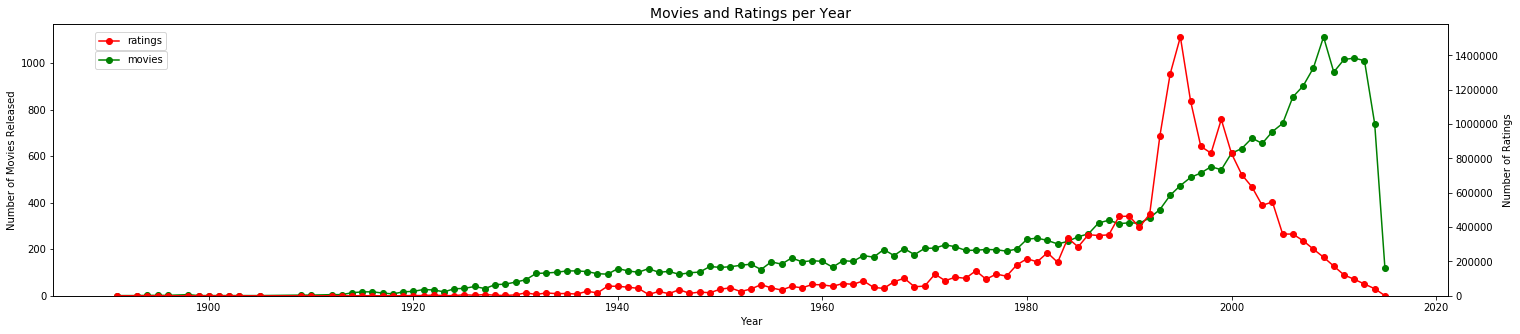

In [91]:
fig, ax1 = plt.subplots(figsize=(25,5))
ax1.plot(year_plot.index, year_plot.movies, "g-o",label="movies")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(0.03, 0.9), loc='upper left', borderaxespad=0.)
ax1.set_ylim(0,)

ax2 = ax1.twinx()
ax2.plot(year_plot.index, year_plot.ratings, "r-o", label="ratings")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(0.03, 0.97), loc='upper left', borderaxespad=0.)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Movies Released'); ax2.set_ylabel('Number of Ratings')
plt.title('Movies and Ratings per Year',fontsize = 14)
plt.show()

The number of movies released grew exponentially from 1900. The rapidest growth happens during 2000-2010. The movies released during the year between 1995 and 2020 are rated the most. After 2020, even if there are more numbers of movies launched, less and less movies are rated.

## b.Movies and Average rating per genre

In [79]:
# Prepare the number of movies per genre daraframe
movie_genre = movies.drop(['title','year'], axis=1).set_index('movieId').stack().reset_index()
movie_genre = movie_genre[movie_genre[0] == True].iloc[:,0:2].rename(columns = {'level_1': 'genre'})
moviecount_genre = movie_genre.groupby('genre')['movieId'].nunique().reset_index().rename(columns = {'movieId': 'stats'})
# Prepare average ratings per genre daraframe
rating_genre = ratings.groupby('movieId')['rating'].mean().reset_index()
rating_genre = rating_genre.merge(movie_genre,on = 'movieId')
avgrating_genre = rating_genre.groupby('genre')['rating'].mean().reset_index().rename(columns = {'rating': 'stats'})
# Combine both for plot
moviecount_genre['line'] = 'num of movies'
avgrating_genre['line'] = 'avg rating'
genre_plot = pd.concat([moviecount_genre,avgrating_genre], axis = 0)
genre_plot = genre_plot.pivot(index='genre', columns='line', values='stats')

In [201]:
genre_plot.head()

line,avg rating,num of movies
genre,,
(no genres listed),2.771531,237.0
Action,2.976834,3519.0
Adventure,3.072407,2329.0
Animation,3.177095,1027.0
Children,2.955608,1139.0


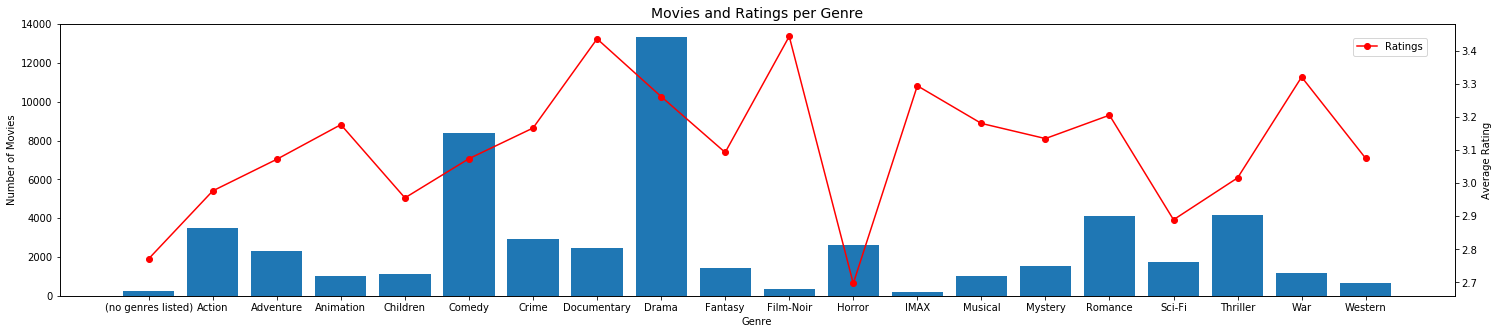

In [92]:
fig, ax3 = plt.subplots(figsize=(25,5))
ax3.bar(genre_plot.index, genre_plot['num of movies'])
ax3.grid(False)

ax4 = ax3.twinx()
ax4.plot(genre_plot.index,genre_plot['avg rating'], "r-o", label = 'Ratings')
ax4.legend(bbox_to_anchor=(0.98, 0.95), loc='upper right', borderaxespad=0.)
ax4.grid(False)

ax3.set_xlabel('Genre')
ax3.set_ylabel('Number of Movies'); ax4.set_ylabel('Average Rating')
plt.title('Movies and Ratings per Genre',fontsize = 14)
plt.show()

Drama and Comedy are two most common types of movies in the market. But Documentary and Film-Noir movies are highest rated movies on average, whereas horror movie is the most low-rated type on average.

## c. Frequent words in movie title for different rating level

I found that there are a lot of movies rated with different scores, which made it hard to find some useful insight that tells us the title/topic difference across different ratings. 
There are several ways I tried to make the result more meaningful:

1. Do not filter out the duplicate rating score for each movie, which shows how many times one movie title were rated with that score.
2. Remove the blockbuster movies that are rated by a lot of people, so that the diversity would be a lot less impacted.
3. Remove the movies with extremely less ratings and users with extremely less movies in order to make the visualization less computational heavy and make the insight more general. Because the number of ratings for each user or movie is very right-skewed, which means there are a lot of users who have only rated a few movies and a lot of movies that have only been rated by a few users.

In [151]:
# We want to remove the movies with extremely less ratings and users with extremely less movies.
rating_movie = ratings.groupby('movieId')['rating'].count()
rating_movie.index = rating_movie.index.map(int)
movie_benchmark = round(rating_movie.quantile(0.7),0)
drop_movie_list = rating_movie[rating_movie < movie_benchmark].index
print('Movie minimum number of reviews: {}'.format(movie_benchmark))

rating_user = ratings.groupby('userId')['rating'].count()
rating_user.index = rating_user.index.map(int)
user_benchmark = round(rating_user.quantile(0.7),0)
drop_user_list = rating_user[rating_user < user_benchmark].index
print('User minimum number of reviews: {}'.format(user_benchmark))

# We also want to drop those blockbusters 
# blockbusters here are defined as movies that have the number of ratings within 1%)
blockbuster_benchmark = round(rating_movie.quantile(0.99),0)
drop_hotmovie_list = rating_movie[rating_movie > blockbuster_benchmark].index
print('Movie maximum number of reviews: {}'.format(blockbuster_benchmark))

ratings = ratings[~ratings['movieId'].isin(drop_movie_list)]
ratings = ratings[~ratings['userId'].isin(drop_user_list)]
ratings = ratings[~ratings['movieId'].isin(drop_hotmovie_list)]

ratings = ratings.reset_index().drop(['index'],axis = 1)

Movie minimum number of reviews: 1286.0
User minimum number of reviews: 354.0
Movie maximum number of reviews: 17620.0


In [152]:
movie_rating = ratings.drop(['userId','timestamp','year'], axis = 1)
movie_rating = movie_rating.merge(movies.loc[:,['movieId','title']], on = 'movieId')

In [153]:
rate_corpus = {}
for i in range(1,6):
    selected_movies = movie_rating[movie_rating['rating'] == i]
    title_corpus = ' '.join(selected_movies['title'])
    rate_corpus[i] = title_corpus
rate_corpus_df = pd.DataFrame.from_dict(rate_corpus, orient='index', columns = ['titles'])

In [154]:
# Some common data cleaning in NLP 
# - remove punctuations,numbers, stop words...
# - lower case
import re
import string
from sklearn.feature_extraction import text 

def clean_text(corpus):
    corpus = corpus.lower()
    corpus = re.sub('[%s]' % re.escape(string.punctuation), '', corpus) # remove punctuations
    corpus = re.sub('\w*\d\w*', '', corpus) # remove numbers
    return corpus

corpus_cleaned = pd.DataFrame(rate_corpus_df.titles.apply(clean_text))
corpus_cleaned

,titles
1,jumanji jumanji jumanji jumanji jumanji jumanj...
2,jumanji jumanji jumanji jumanji jumanji jumanj...
3,jumanji jumanji jumanji jumanji jumanji jumanj...
4,jumanji jumanji jumanji jumanji jumanji jumanj...
5,jumanji jumanji jumanji jumanji jumanji jumanj...


In [155]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(corpus_cleaned.titles)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = corpus_cleaned.index
data = data_dtm.transpose()
data_dtm

,aardman,abre,absentminded,absolute,abyss,academy,according,accused,ace,act,...,zissou,zodiac,zoe,zombieland,zone,zoolander,zorro,átame,åmål,über
1,37,16,37,42,99,2439,32,5,700,510,...,59,20,49,24,108,177,152,17,2,46
2,50,35,115,218,385,2297,123,27,1061,973,...,136,56,133,43,319,428,525,71,24,80
3,186,168,486,688,1553,2468,421,212,1240,1596,...,399,337,338,274,872,970,1494,274,119,225
4,796,506,424,462,2311,930,604,432,541,796,...,787,733,298,750,906,900,1469,271,259,444
5,768,143,87,53,701,141,160,72,106,116,...,289,114,72,155,186,185,245,84,71,480


In [156]:
# Find the top 30 words showed in each rating sections
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))
# Print the top 15 words showed in each rating sections
for rating, top_words in top_dict.items():
    print(rating)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

1
ii, iii, man, police, aka, academy, star, movie, wild, dead, batman, kid, trek, city
---
2
ii, man, iii, aka, star, men, dead, trek, world, american, lost, batman, days, big
---
3
ii, man, star, aka, dead, men, trek, iii, american, world, big, harry, days, story
---
4
man, dead, ii, aka, star, men, harry, life, big, american, story, good, trek, love
---
5
man, life, dead, aka, ii, big, story, love, il, men, american, star, harry, good
---


In [157]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each rating
words = []
for rating in data.columns:
    top = [word for (word, count) in top_dict[rating]]
    for t in top:
        words.append(t)     

In [158]:
# If more than 4 ratings have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 3]

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(corpus_cleaned.titles)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = corpus_cleaned.index

from wordcloud import WordCloud
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

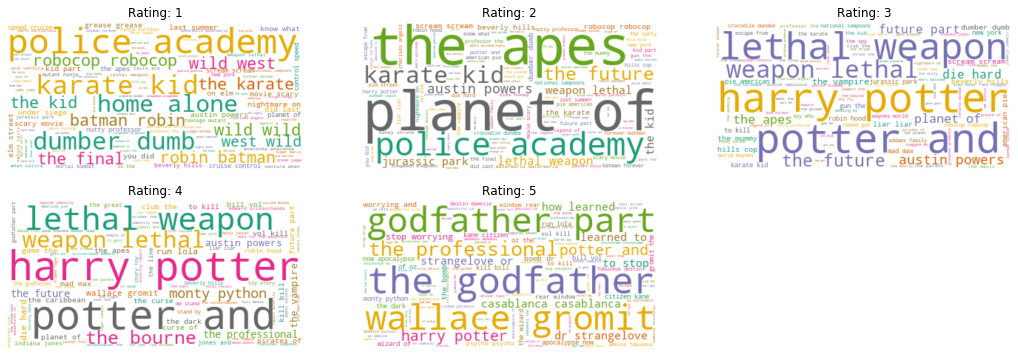

In [159]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18, 6]
Ratings = ['Rating: 1', 'Rating: 2', 'Rating: 3', 'Rating: 4', 'Rating: 5']
# Create subplots for each rating score
for index, rating in enumerate(data.columns):
    wc.generate(corpus_cleaned.titles[rating])
    
    plt.subplot(2, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(Ratings[index])
    
plt.show()

Wordcloud can not be seen as a serious visualization analysis, because there are a lot of issues that need to be considered and filtered, which would never end. For example, even if we kind of solved the problem of popularity differences, Some movies could be still outstanding in the wordcloud only because there are more seasons. So we can see this wordcloud visualization as an exploratory step.


